### Step 5: Machine Learning Model Evaluation

This notebook loads feature and label data from a csv file, which was generated in the previous "data wrangling" step. The last column in the csv file are labels. The rest columns are features.

We use the data to train and evaluate various machine learning models. The purpose of this notebook is to find out the accuracy of these machine learning models with the training features. The training features and model parameters can be tweaked in order to find the optimal model which is most suitable for our research goal.

Here we use scikit-learn as example. Other machine learning platforms are available, such as TensorFlow, Keras and PyTorch. If you don't like coding, maybe try "Ludwig" or "Northstar" (not recommended for this practical ... unless you are already a machine learning expert).

Cross validate the machine learning model 10 times.
Evaluate the 10 scores to decide if the model is good enough to be used to predict new data.

Scores: [0.74, 0.93, 0.88, 0.89, 0.93, 0.78, 0.9, 0.96, 0.88, 0.78]
Score Mean: 0.87, Score Standard Deviation: 0.0709
Accuracy: 0.87 (+/- 0.1418)      #95% confidence interval of the score estimate


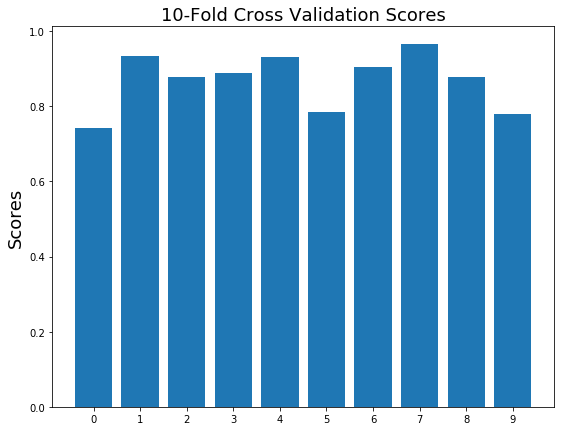

In [1]:
%matplotlib inline

#Import the tools for machine learning
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#read in data for machine learning training and testing
candidates= pd.read_csv('ml_case_1_candidates.csv')
positive = pd.read_csv('ml_case_1_positive.csv')
negative = pd.read_csv('ml_case_1_negative.csv')

train_test_data = pd.concat([positive, negative])

labels = train_test_data.iloc[:,-1]
data = train_test_data.iloc[:,:-1]

#choose classifier
classifier = 'RFC' #random forest
#classifier = 'SVC' #support vector Classification 

#preprocess features and split data for training and testing
data = preprocessing.scale(data)
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=1)

if classifier == 'RFC':
    #create and train the random forest
    #multi-core CPUs can use: rf = RandomForestClassifier(n_estimators=100, n_jobs=2)
    #n_estimators use between 64-128 doi: 10.1007/978-3-642-31537-4_13
    clf = RandomForestClassifier(n_estimators=128, n_jobs=1,class_weight=None)
elif classifier == 'SVC':
    clf = SVC(probability=True,class_weight=None, gamma='auto')
    
#cross validate the estimator    
#https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation
scores = cross_val_score(clf, data, labels, cv=10)
print('Cross validate the machine learning model 10 times.')
print('Evaluate the 10 scores to decide if the model is good enough to be used to predict new data.\n')
print(f"Scores: {[round(x,2) for x in scores]}")
print(f"Score Mean: {round(np.mean(scores), 2)}, Score Standard Deviation: {round(np.std(scores),4)}")
print(f"Accuracy: {round(np.mean(scores), 2)} (+/- {round(np.std(scores)*2,4)})\
      #95% confidence interval of the score estimate")

#plot the bar chart
fig, ax = plt.subplots(figsize=(9, 7))
plt.bar(np.arange(10), scores)
ax.set_ylabel('Scores', fontsize=18)
ax.set_title('10-Fold Cross Validation Scores',fontsize=18)
ax.set_xticks(np.arange(10))
plt.show()

Use the train dataset to train the model and predict on the test dataset.
The bar chart indicates the model's prediction of deposit probabilities.
Score with train and test data: 0.94


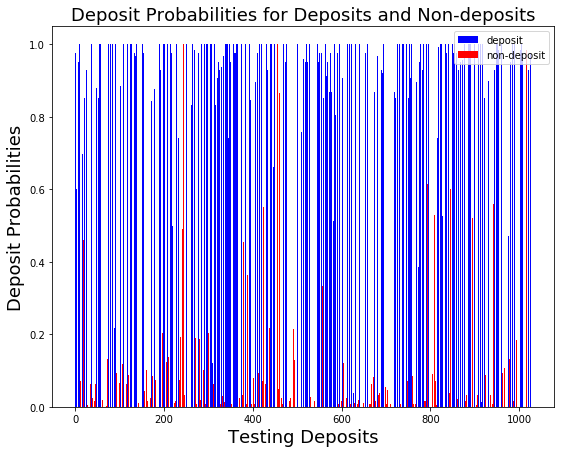

In [2]:
#train the machine learning model with train and test data
#and then predict
clf.fit(train_data, train_labels)
score=clf.score(test_data, test_labels)
print('Use the train dataset to train the model and predict on the test dataset.')
print('The bar chart indicates the model\'s prediction of deposit probabilities.')
print(f'Score with train and test data: {round(score,2)}')

proba=clf.predict_proba(test_data)
predict_labels=clf.predict(test_data)

#plot the probabilities
fig, ax = plt.subplots(figsize=(9, 7))
tmp = np.c_[np.arange(len(proba)), test_labels, proba]
deposit = tmp[tmp[:,1]==1]
non_deposit = tmp[tmp[:,1]==0]
ax.bar(deposit[:,0], deposit[:,3], color='blue', label='deposit')
ax.bar(non_deposit[:,0], non_deposit[:,3], color='red', label='non-deposit')
ax.set_ylabel('Deposit Probabilities', fontsize=18)
ax.set_xlabel('Testing Deposits', fontsize=18)
ax.set_title('Deposit Probabilities for Deposits and Non-deposits',fontsize=18)
plt.legend(loc='upper right')
plt.show()

The bar chart shows the model's prediction of deposit probabilities and 
the colors show the correct prediction, false positive and false negative predictions.


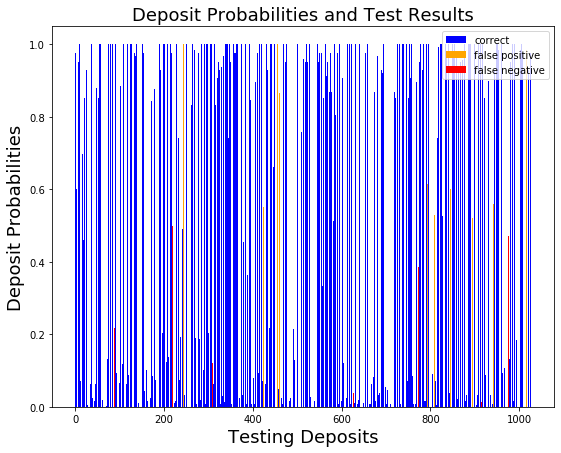

In [3]:
print('The bar chart shows the model\'s prediction of deposit probabilities and ')
print('the colors show the correct prediction, false positive and false negative predictions.')
#plot the probabilities with true, false positive and false negative
fig, ax = plt.subplots(figsize=(9, 7))
tmp = np.c_[np.arange(len(proba)), predict_labels, test_labels, proba]
correct_predict = tmp[tmp[:,1]==tmp[:,2]]
tmp=tmp[tmp[:,1]!=tmp[:,2]]
false_positive = tmp[tmp[:,1]==1]
false_negative = tmp[tmp[:,1]==0]
ax.bar(correct_predict[:,0], correct_predict[:,4], color='blue', label='correct')
ax.bar(false_positive[:,0], false_positive[:,4], color='orange', label='false positive')
ax.bar(false_negative[:,0], false_negative[:,4], color='red', label='false negative')
ax.set_ylabel('Deposit Probabilities', fontsize=18)
ax.set_xlabel('Testing Deposits', fontsize=18)
ax.set_title('Deposit Probabilities and Test Results',fontsize=18)
plt.legend(loc='upper right')
plt.show()

For Random Forest model, the bar chart shows the weight of each feature in decision making.
[0.20389397 0.24579278 0.2458475  0.30446575]


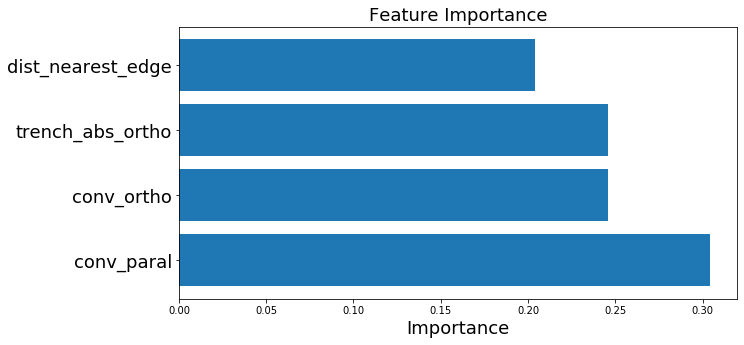

In [4]:
if classifier == 'RFC':
    print('For Random Forest model, the bar chart shows the weight of each feature in decision making.')
    print(clf.feature_importances_)
    #plot the feature importance if using Random Forest Classifier. 
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.barh(np.arange(len(clf.feature_importances_)), clf.feature_importances_)
    ax.set_xlabel('Importance', fontsize=18)
    ax.set_title('Feature Importance',fontsize=18)
    ax.set_yticks(np.arange(len(clf.feature_importances_)))
    #feature_names = ['Seafloor Age', 'Distance Along Trench', 'Trench Absolute Orthogonal',
    #                'Convergence Orthogonal Velocity', 'Convergence Parallel Velocity']
    feature_names = train_test_data.columns[:-1]
    #print(feature_names)
    ax.set_yticklabels(feature_names, rotation=0, fontsize=18)
    ax.invert_yaxis() 
    plt.show()
   

Run the machine learning model on the whole trench sampling points dataset to see which areas have higher proboblilites of mineral deposit. 

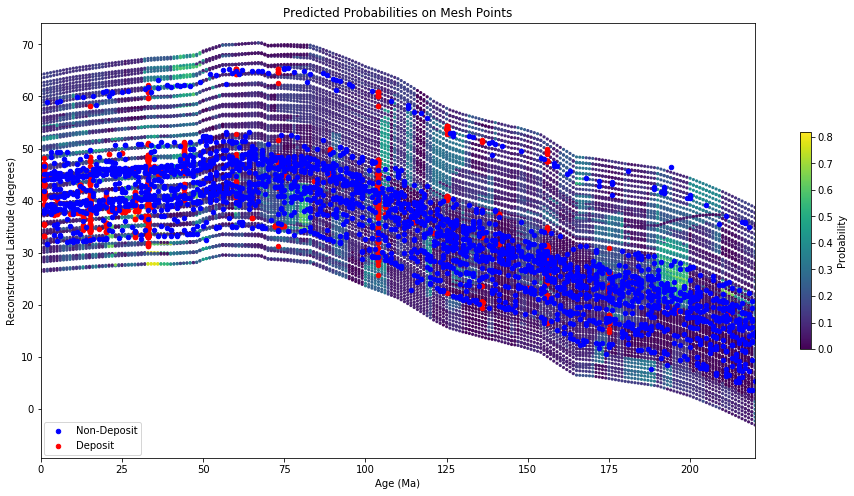

In [5]:
#train the ML model
clf.fit(data, labels)

#read in test data and predict
from parameters import parameters as p
import pandas as pd
import re

all_candidates_data = pd.read_csv('coreg_output/deposit_candidates.csv')
all_positive_data = pd.read_csv('coreg_output/positive_deposits.csv')
all_negative_data = pd.read_csv('coreg_output/negative_deposits.csv')

feature_names=['dist_nearest_edge', 'trench_abs_ortho', 'conv_ortho', 'conv_paral']

positive_idx = all_positive_data[feature_names].dropna().index
negative_idx = all_negative_data[feature_names].dropna().index
candidates_idx = all_candidates_data[feature_names].dropna().index

#display(candidates)
#print(all_candidates_data.iloc[positive.index])
test_data = preprocessing.scale(candidates)
mesh_prob=clf.predict_proba(test_data)

#make a plot
fig, ax = plt.subplots(figsize=(16, 8))
plt.xlim([0,220])
cb = plt.scatter(all_candidates_data.iloc[candidates_idx]['age'],
                 all_candidates_data.iloc[candidates_idx]['recon_lat'], 
                 c=mesh_prob[:,1],s=10,marker='o',edgecolor='none')

p1 = plt.scatter(all_positive_data.iloc[positive_idx]['age'], 
                 all_positive_data.iloc[positive_idx]['recon_lat'], 
                 color='red',s=20,marker='o')
p2 = plt.scatter(all_negative_data.iloc[negative_idx]['age'], all_negative_data.iloc[negative_idx]['recon_lat'],
                 color='blue',s=20,marker='o')

fig.colorbar(cb, shrink=0.5, label='Probability')
plt.title('Predicted Probabilities on Mesh Points')
plt.ylabel('Reconstructed Latitude (degrees)')
plt.xlabel('Age (Ma)')
ax.legend([p2,p1],["Non-Deposit","Deposit"],
            loc=3, borderaxespad=0.3,numpoints=1)

plt.show()

Plot the predicted probobilities on test dataset in "distance along trench" and "age" space.

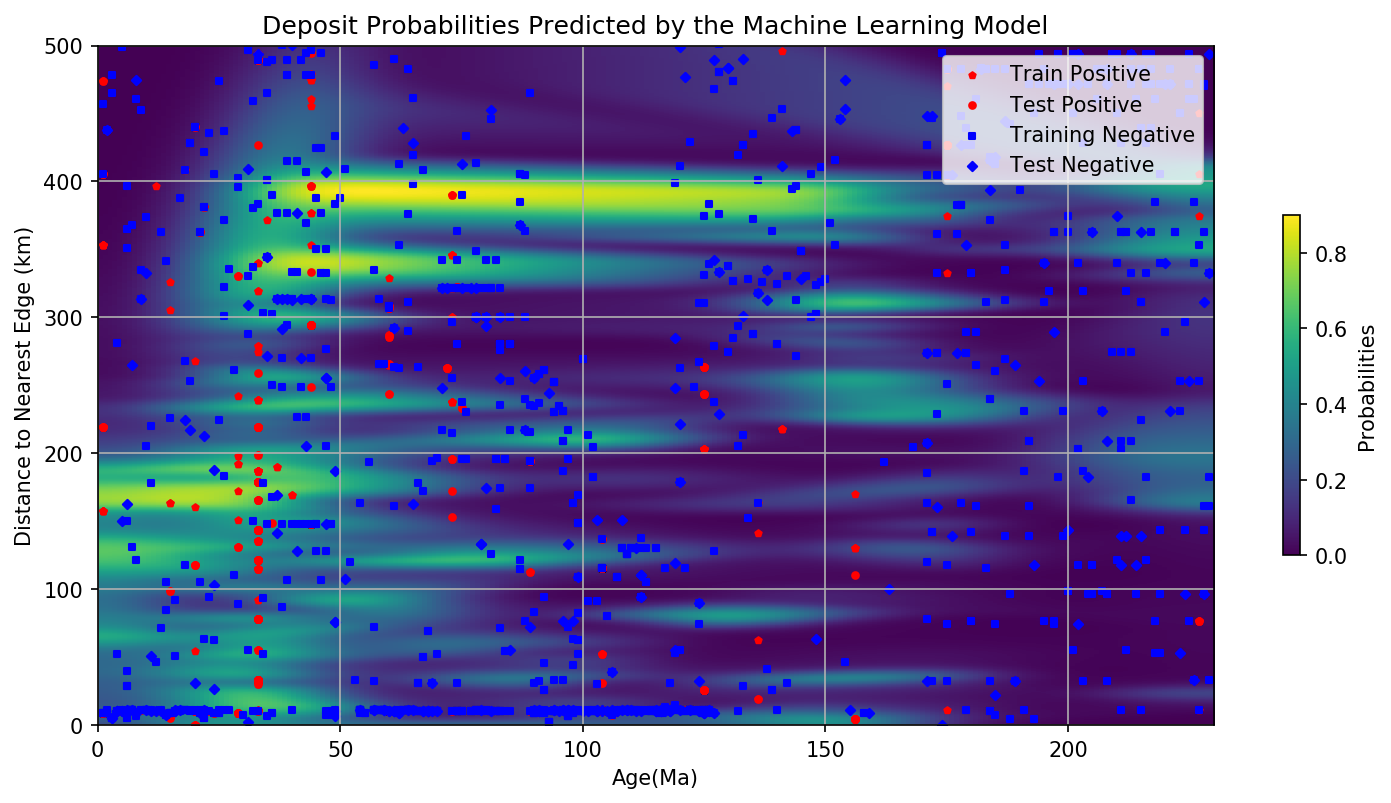

In [6]:
%matplotlib inline

import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import numpy as np
from scipy import misc, ndimage
from parameters import parameters as p

all_positive_data = pd.read_csv('coreg_output/positive_deposits.csv')
all_negative_data = pd.read_csv('coreg_output/negative_deposits.csv')

feature_names=['dist_nearest_edge', 'age', 'trench_abs_ortho', 'conv_ortho', 'conv_paral']

positive = all_positive_data[feature_names].dropna()
positive['label'] = True
negative = all_negative_data[feature_names].dropna()
negative['label'] = False

train_test_data = pd.concat([positive, negative])

#display(train_test_data)

labels = train_test_data.iloc[:,-1]
data = train_test_data.iloc[:,:-1]

#preprocess features and split data for training and testing
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=1)

preprocessed_train_data = preprocessing.scale(train_data)
preprocessed_test_data = preprocessing.scale(test_data)

clf.fit(preprocessed_train_data, train_labels)
proba=clf.predict_proba(preprocessed_test_data)
    
train_positive=train_data[train_labels==1]
train_negative=train_data[train_labels==0]
test_positive=test_data[test_labels==1]
test_negative=test_data[test_labels==0]

fig = plt.figure(figsize=(12,6),dpi=150)
ax = plt.axes()
plt.xlim([0,230])
plt.ylim([0,500])

grid_x, grid_y = np.mgrid[0:231, 0:6501]
grid_data = griddata(list(zip(test_data['age'], test_data['dist_nearest_edge']* 6371. * np.pi / 180)), proba[:,1], 
                     (grid_x, grid_y), method='linear', fill_value=0)
grid_data = ndimage.gaussian_filter(grid_data, sigma=10)


p1=ax.scatter(train_positive['age'], train_positive['dist_nearest_edge']* 6371. * np.pi / 180, 10, marker='p',c='red')
p2=ax.scatter(test_positive['age'], test_positive['dist_nearest_edge']* 6371. * np.pi / 180, 10, marker='o',c='red')
p3=ax.scatter(train_negative['age'], train_negative['dist_nearest_edge']* 6371. * np.pi / 180, 10, marker='s',c='blue')
p4=ax.scatter(test_negative['age'], test_negative['dist_nearest_edge']* 6371. * np.pi / 180, 10, marker='D',c='blue')

plt.legend([p1,p2,p3,p4],\
           ["Train Positive","Test Positive","Training Negative",'Test Negative'],
           loc=1)

cb=plt.imshow(grid_data.T, extent=(0,230,0, 2000), origin='lower', aspect='auto')
fig.colorbar(cb, shrink=0.5, label='Probabilities')
plt.xlabel('Age(Ma)')
plt.ylabel('Distance to Nearest Edge (km)')
plt.title('Deposit Probabilities Predicted by the Machine Learning Model')
plt.grid()
plt.show()

 ##### Mesh Points Coloured by Mean Probability
 This cell calculates the mean probabilites along time for each mesh points and draw a map with mesh points coloured by mean probablities.

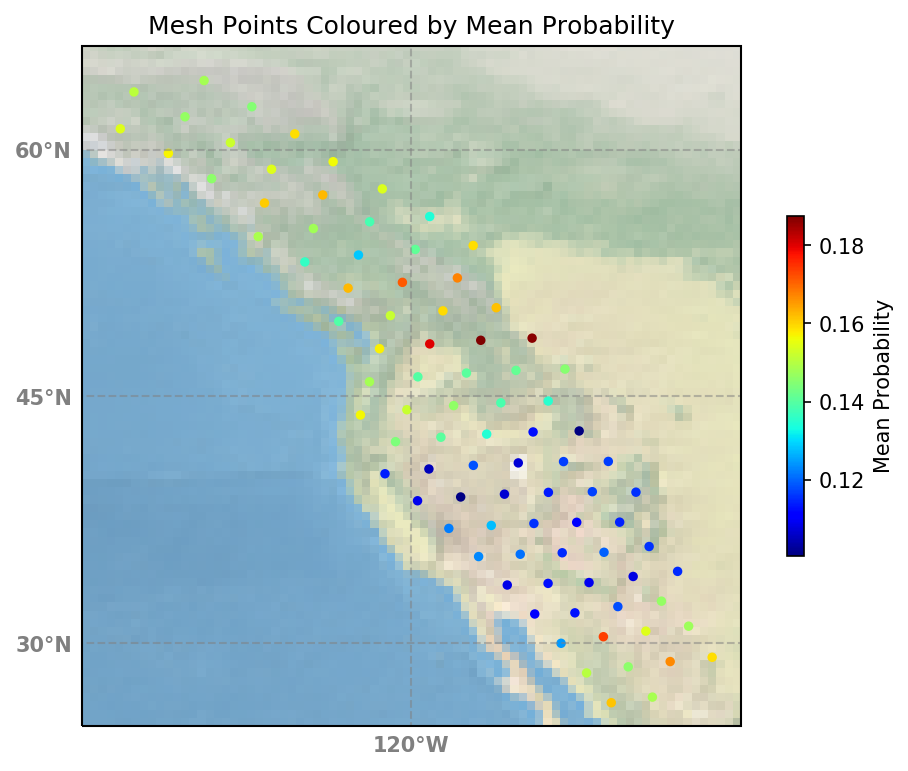

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

candidates_lat_lon = all_candidates_data.iloc[candidates_idx][['lon','lat', 'age']]
candidates_lat_lon['prob'] = mesh_prob[:,1]
candidates_lat_lon = candidates_lat_lon.groupby(['lon','lat'])['prob'].mean()
#candidates_lat_lon.sort_values(ascending=False, inplace=True)

candidates_lat_lon = candidates_lat_lon.reset_index()

lons = candidates_lat_lon['lon']
lats = candidates_lat_lon['lat']

#plot the data    
fig = plt.figure(figsize=(8,6),dpi=150)
ax = plt.axes(projection=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlocator = mticker.FixedLocator([-180, -150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150, 180])
gl.ylocator = mticker.FixedLocator([-90, -75, -60, -45, -30, -15, 0, 15, 30, 45, 60, 75, 90])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'color': 'gray', 'weight': 'bold'}
gl.ylabel_style = {'color': 'gray', 'weight': 'bold'}

ax.stock_img()
#ax.set_extent([-180, 180, -90, 90])
ax.set_extent([-140, -100, 25, 65])
cb = ax.scatter(lons, lats, 50, marker='.',c=candidates_lat_lon['prob'], cmap=plt.cm.jet)

plt.title('Mesh Points Coloured by Mean Probability')
fig.colorbar(cb, shrink=0.5, label='Mean Probability')
plt.show()

##### Top 9 Highest Mean probability Locations
This cell draws 9 subplots to show the probability changes along time for the top 9 highest mean probablity location.

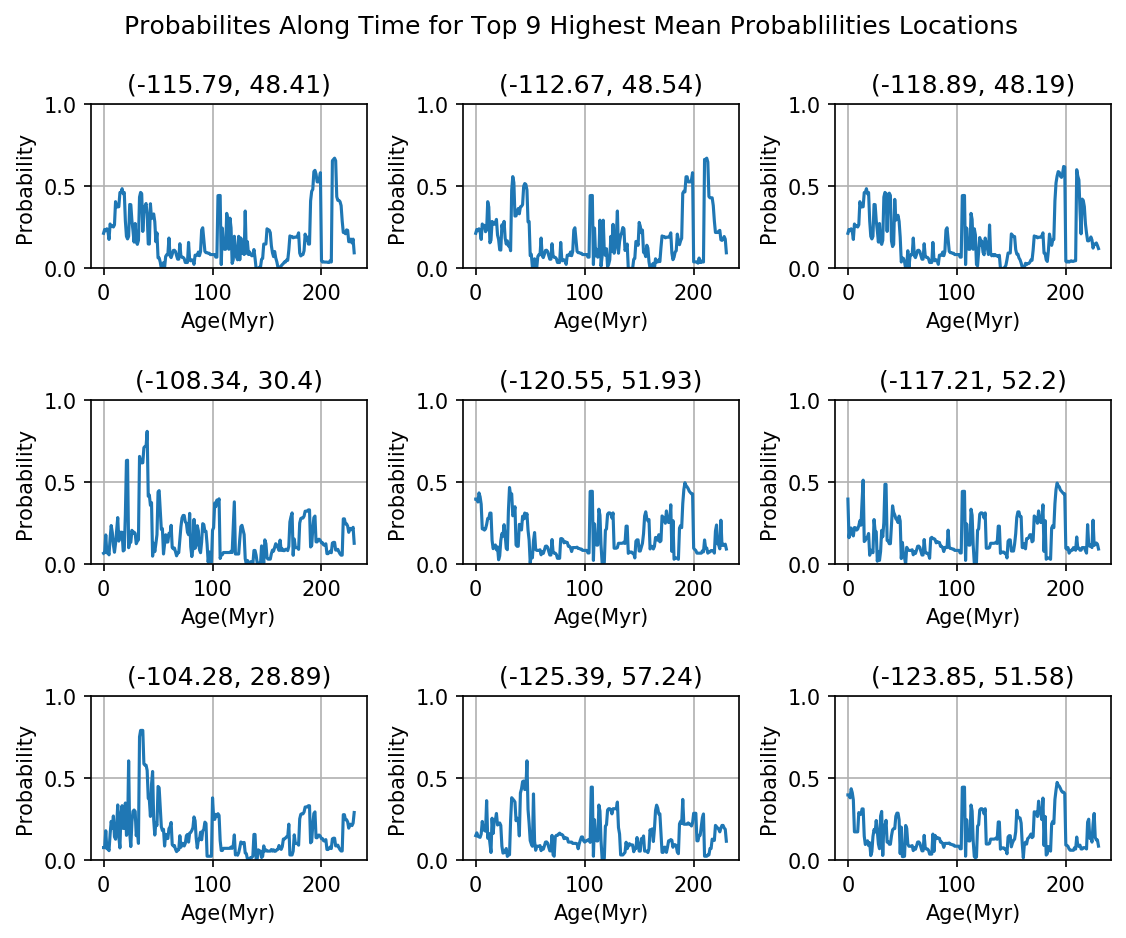

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

candidates_lat_lon = all_candidates_data.iloc[candidates_idx][['lon','lat', 'age']]
candidates_lat_lon['prob'] = mesh_prob[:,1]
candidates_lat_lon = candidates_lat_lon.groupby(['lon','lat'])

prob_means = candidates_lat_lon['prob'].mean().sort_values(ascending=False)
prob_means = prob_means.head(10)

fig = plt.figure(figsize=(8,6),dpi=150)

for i in range(9):
    plt.subplot(330+i+1)
    tmp = candidates_lat_lon.get_group(prob_means.index[i])
    plt.plot(tmp['age'], tmp['prob'])
    plt.xlabel('Age(Myr)')
    plt.ylabel('Probability')
    plt.ylim(0,1)
    plt.title(f'{prob_means.index[i]}')
    plt.grid(True)
  

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.8,
                    wspace=0.35)
plt.suptitle('Probabilites Along Time for Top 9 Highest Mean Probablilities Locations',y=1.02)
plt.show()

##### Mesh Points Coloured by Max probability
For each mesh points, we calculate the probablities of being ore deposits for each age value from start time to end time, such as 230Ma, 229Ma, ...., 0Ma.

This cell draw two maps. 

One(on the left) is coloured by the max probablity, which is the highest probablity among probablities calculated with all age values. It means the mesh point location has the highest probablity when its age is T. 

The other map(on the right) is coloured by age, which is the T mentioned above.

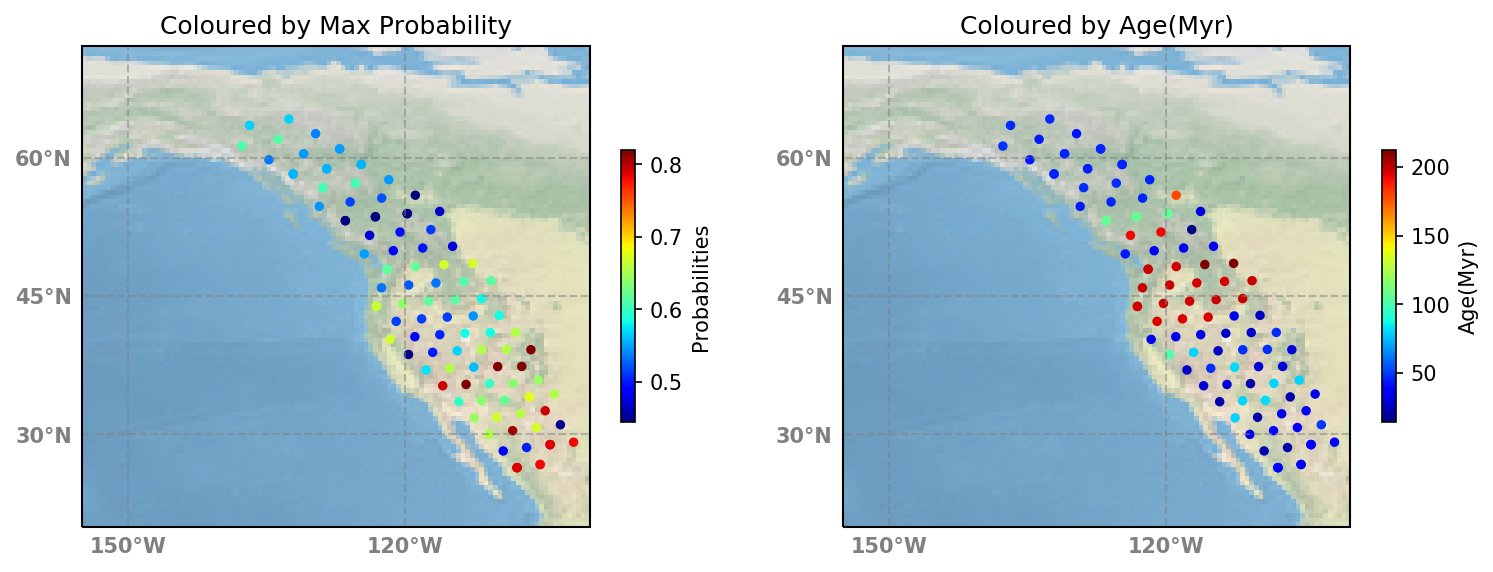

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

candidates_lat_lon = all_candidates_data.iloc[candidates_idx][['lon','lat', 'age']]
candidates_lat_lon['prob'] = mesh_prob[:,1]
idx = candidates_lat_lon.groupby(['lon','lat'])['prob'].transform(max) == candidates_lat_lon['prob']
candidates_lat_lon = candidates_lat_lon[idx]

#display(candidates_lat_lon.sort_values(by=['prob'],ascending=False))
def set_ax(ax):
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xlocator = mticker.FixedLocator([-180, -150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150, 180])
    gl.ylocator = mticker.FixedLocator([-90, -75, -60, -45, -30, -15, 0, 15, 30, 45, 60, 75, 90])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'color': 'gray', 'weight': 'bold'}
    gl.ylabel_style = {'color': 'gray', 'weight': 'bold'}

    ax.stock_img()
    #ax.set_extent([-180, 180, -90, 90])
    ax.set_extent([-155, -100, 20, 70])

#plot the data    
fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw={'projection': ccrs.PlateCarree()},figsize=(12,12),dpi=150)
set_ax(ax1)
set_ax(ax2)

cb1 = ax1.scatter(candidates_lat_lon['lon'], candidates_lat_lon['lat'], 50, marker='.', 
                  c=candidates_lat_lon['prob'], cmap=plt.cm.jet)
cb2 = ax2.scatter(candidates_lat_lon['lon'], candidates_lat_lon['lat'], 50, marker='.', 
                  c=candidates_lat_lon['age'], cmap=plt.cm.jet)
ax1.title.set_text('Coloured by Max Probability')
ax2.title.set_text('Coloured by Age(Myr)')
fig.colorbar(cb2, shrink=0.2, label='Age(Myr)', ax=ax2)
fig.colorbar(cb1, shrink=0.2, label='Probabilities', ax=ax1)
plt.show()

### THE END